In [64]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow.keras as tfk
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Conv2D, MaxPool2D, MaxPooling2D, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras import layers
import sys

'''
Some code modified from that provided by Daniel Sawyer.  This implementation
is done with functions for a different look.  You do not have to use it.
You will work with cifar100 as set up here (in terms of train, validation
and test).  This is color images of size 32x32 of 100 classes. Hence, 3
chanels R, G, B.    I took out 10% for validation.
You can change this around, but must be very clear on what was done and why.
You must improve on 44% accuracy (which is a fairly low bar).  You need to
provide a best class accuracy and worst class accuracy. To improve, more epochs
can help, but that cannot be the only change you make.  You should show  better
performance at 15 epochs or argue why it is not possible.  You can add layers,
subtract layers (though you have 100 classes). You need to report on the number
of examples.

I also want you to use a snapshot ensemble of at least 5 snapshots.  One
way to choose the best class is to sum the per class outputs and take the
maximum.  Another is to vote for the class and break ties in some way.
Indicate if results are better or worse or the same. (This is 5
extra credit points of the grade).

You must clearly explain what you tried and why and what seemed to work
and what did not.  That will be the major part of your grade.  Higher
accuracy will also improve your grade. If you use an outside source, it
must be disclosed and that source may be credited with part of the grade.
 The best accuracy in class will add
3 points to their overall average grade, second best 2 points and 3rd best
 1 point.

To get predictions:
predictions=model.predict(ds_test)
Prints the first test predition and you will see 100 predictions
print(predictions[0])

'''

def loadmycifar100():
  # cifar100 has 2 sets of labels.  The default is "label" giving you 100
  # predictions for the classes
  (ds_train, dsvalid, ds_test), ds_info = tfds.load(
    'cifar100',
# First 35% and last 55% from training, then validation data is 10%
# from 35% of train data to 41+% and test is the usual 10K
    split=['train[:35%]+train[-55%:]','train[35%:45%]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
#tf.keras.datasets.cifar100.load_data(label_mode="fine")


#  ds_train = ds_train.map(
#    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds_train = ds_train.cache()
  ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
  ds_train = ds_train.batch(50)
  ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

#  ds_test = ds_test.map(
#    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds_test = ds_test.batch(50)
  ds_test = ds_test.cache()
  ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)


#  dsvalid = dsvalid.map(
#    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dsvalid = dsvalid.batch(64)
  dsvalid = dsvalid.cache()
  dsvalid = dsvalid.prefetch(tf.data.experimental.AUTOTUNE)
  return ds_train, dsvalid, ds_test


In [38]:
def create_plot(history, title=""):

  # Plot training and validation loss
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  # Plot training and validation accuracy
  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.suptitle(title)

  plt.tight_layout()  # Ensures plots are displayed nicely without overlapping

  plt.show()

## Variables

In [39]:
(ds_train, dsvalid, ds_test) = loadmycifar100()
epochs = 15
# Callback for saving best epoch checkpoint weights
# Input shape and layer.  This is rgb
input_shape = (32, 32, 3)
opt = tfk.optimizers.legacy.Adam(learning_rate = 0.0004, decay = 1e-6)

## Models

In [46]:
def base_model():
    input_layer = tfk.layers.Input(shape=input_shape)

    # First convolution, batch norm
    ly = tfk.layers.Conv2D(32, 3)(input_layer)
    ly = tfk.layers.BatchNormalization()(ly)
    ly = tfk.layers.Activation('relu')(ly)

    ly = tfk.layers.MaxPooling2D()(ly)

    # Second convolution, batch norm
    ly = tfk.layers.Conv2D(64, 3)(ly)
    ly = tfk.layers.BatchNormalization()(ly)
    ly = tfk.layers.Activation('relu')(ly)


    # Max pooling layer and flattens for dense layers
    ly = tfk.layers.MaxPooling2D()(ly)
    ly = tfk.layers.Flatten()(ly)

    # First dense layer with batch norm & dropout
    ly = tfk.layers.Dense(512)(ly)
    ly = tfk.layers.BatchNormalization()(ly)
    ly = tfk.layers.Activation('relu')(ly)
    ly = tfk.layers.Dropout(0.5)(ly)

    # Output dense layer, 100 classes
    ly = tfk.layers.Dense(100)(ly)
    output_layer = tfk.layers.Activation('softmax')(ly)

    # Compiles model with adam optimizer
    model = tfk.Model(input_layer, output_layer)

    model.compile(
	  	loss='sparse_categorical_crossentropy',
			optimizer=opt,
			metrics=['accuracy']
    )

    return model

In [47]:
def model_v2():

    """Model Uses Global Average Pooling 2D"""

    input_layer = tfk.layers.Input(shape=input_shape)

    # First convolution, batch norm
    ly = tfk.layers.Conv2D(32, 3)(input_layer)
    ly = tfk.layers.BatchNormalization()(ly)
    ly = tfk.layers.Activation('relu')(ly)

    ly = tfk.layers.MaxPooling2D()(ly)

    # Second convolution, batch norm
    ly = tfk.layers.Conv2D(64, 3)(ly)
    ly = tfk.layers.BatchNormalization()(ly)
    ly = tfk.layers.Activation('relu')(ly)

    # Global Average Pooling layer and dropout
    ly = tf.keras.layers.GlobalAveragePooling2D()(ly)
    ly = tfk.layers.Dropout(0.3)(ly)

    # Output dense layer, 100 classes
    ly = tfk.layers.Dense(100)(ly)
    output_layer = tfk.layers.Activation('softmax')(ly)

    # Compiles model with adam optimizer
    model = tfk.Model(input_layer, output_layer)

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy']
    )

    return model



In [48]:
def model_v3():

    """Model Uses Global Average Pooling 2D and 2 stacks of Conv Units in Each Layer"""

    input_layer = tfk.layers.Input(shape=input_shape)

    # First convolution, batch norm
    ly = tfk.layers.Conv2D(32, 3)(input_layer)
    ly = tfk.layers.BatchNormalization()(ly)
    ly = tfk.layers.Activation('relu')(ly)

    ly = tfk.layers.Conv2D(32, 3)(ly)
    ly = tfk.layers.BatchNormalization()(ly)
    ly = tfk.layers.Activation('relu')(ly)

    ly = tfk.layers.MaxPooling2D()(ly)

    # Second convolution, batch norm
    ly = tfk.layers.Conv2D(64, 3)(ly)
    ly = tfk.layers.BatchNormalization()(ly)
    ly = tfk.layers.Activation('relu')(ly)

    ly = tfk.layers.Conv2D(64, 3)(ly)
    ly = tfk.layers.BatchNormalization()(ly)
    ly = tfk.layers.Activation('relu')(ly)

    # Global Average Pooling layer and dropout
    ly = tf.keras.layers.GlobalAveragePooling2D()(ly)
    ly = tfk.layers.Dropout(0.3)(ly)

    # Output dense layer, 100 classes
    ly = tfk.layers.Dense(100)(ly)
    output_layer = tfk.layers.Activation('softmax')(ly)

    # Compiles model with adam optimizer
    model = tfk.Model(input_layer, output_layer)

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy']
    )

    return model


In [49]:
def model_v4():

    input_layer = tfk.layers.Input(shape=input_shape)

    # First convolution, batch norm
    ly = tfk.layers.Conv2D(32, 3, padding='same')(input_layer)
    ly = tfk.layers.BatchNormalization()(ly)
    ly = tfk.layers.Activation('relu')(ly)

    ly = tfk.layers.Conv2D(32, 3, padding='same')(ly)
    ly = tfk.layers.BatchNormalization()(ly)
    ly = tfk.layers.Activation('relu')(ly)

    ly = tfk.layers.MaxPooling2D()(ly)

    # Second convolution, batch norm
    ly = tfk.layers.Conv2D(64, 3, padding='same')(ly)
    ly = tfk.layers.BatchNormalization()(ly)
    ly = tfk.layers.Activation('relu')(ly)

    ly = tfk.layers.Conv2D(64, 3, padding='same')(ly)
    ly = tfk.layers.BatchNormalization()(ly)
    ly = tfk.layers.Activation('relu')(ly)

    ly = tfk.layers.MaxPooling2D()(ly)

    # Third convolution layer, batch norm
    ly = tfk.layers.Conv2D(128, 3, padding='same')(ly)
    ly = tfk.layers.BatchNormalization()(ly)
    ly = tfk.layers.Activation('relu')(ly)

    ly = tfk.layers.Conv2D(128, 3, padding='same')(ly)
    ly = tfk.layers.BatchNormalization()(ly)
    ly = tfk.layers.Activation('relu')(ly)

    # Global Average Pooling layer and dropout
    ly = tf.keras.layers.GlobalAveragePooling2D()(ly)
    ly = tfk.layers.Dropout(0.3)(ly)

    # Output dense layer, 100 classes
    ly = tfk.layers.Dense(100)(ly)
    output_layer = tfk.layers.Activation('softmax')(ly)

    # Compiles model with adam optimizer
    model = tfk.Model(input_layer, output_layer)

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy']
    )

    return model

In [50]:
def residual_block(x, f, k, pooling=True):

  r = x
  x = tfk.layers.Conv2D(f, k, padding='same')(x)
  x = tfk.layers.BatchNormalization()(x)
  x = tfk.layers.Activation('relu')(x)

  x = tfk.layers.Conv2D(f, k, padding='same')(x)
  x = tfk.layers.BatchNormalization()(x)
  x = tfk.layers.Activation('relu')(x)

  if pooling:
    x = tfk.layers.MaxPooling2D()(x)
    r = tfk.layers.Conv2D(f, 1, strides=2)(r)
  else:
    r = tfk.layers.Conv2D(f, 1)(r)

  return tfk.layers.add([x, r])

def model_v5():

    input_layer = tfk.layers.Input(shape=input_shape)
    ly = tfk.layers.Rescaling(1./255)(input_layer)
    # First convolution, batch norm
    ly = tfk.layers.Conv2D(32, 3, padding='same')(ly)
    ly = tfk.layers.BatchNormalization()(ly)
    ly = tfk.layers.Activation('relu')(ly)
    r = ly

    ly = tfk.layers.Conv2D(32, 3, padding='same')(ly)
    ly = tfk.layers.BatchNormalization()(ly)
    ly = tfk.layers.Activation('relu')(ly)

    ly = tfk.layers.MaxPooling2D()(ly)

    r = tfk.layers.Conv2D(32, 1, strides=2)(r)

    ly = tfk.layers.add([ly, r])

    # Second convolution, batch norm
    ly = residual_block(ly, 64, 3)

    # Third convolution layer, batch norm
    ly = residual_block(ly, 128, 3, False)


    # Global Average Pooling layer and dropout
    ly = tf.keras.layers.GlobalAveragePooling2D()(ly)
    ly = tfk.layers.Dropout(0.5)(ly)

    # Output dense layer, 100 classes
    ly = tfk.layers.Dense(100)(ly)
    output_layer = tfk.layers.Activation('softmax')(ly)

    # Compiles model with adam optimizer
    model = tfk.Model(input_layer, output_layer)

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy']
    )

    return model

In [51]:
def model_v6():

    augmentation = tfk.Sequential([
        tfk.layers.RandomFlip('horizontal'),
        tfk.layers.RandomRotation(0.1),
        tfk.layers.RandomZoom(0.2)
    ])

    input_layer = tfk.layers.Input(shape=input_shape)
    ly = augmentation(input_layer)
    ly = tfk.layers.Rescaling(1./255)(ly)
    # First convolution, batch norm
    ly = tfk.layers.Conv2D(32, 3, padding='same')(ly)
    ly = tfk.layers.BatchNormalization()(ly)
    ly = tfk.layers.Activation('relu')(ly)
    r = ly

    ly = tfk.layers.Conv2D(32, 3, padding='same')(ly)
    ly = tfk.layers.BatchNormalization()(ly)
    ly = tfk.layers.Activation('relu')(ly)

    ly = tfk.layers.MaxPooling2D()(ly)

    r = tfk.layers.Conv2D(32, 1, strides=2)(r)

    ly = tfk.layers.add([ly, r])

    # Second convolution, batch norm
    ly = residual_block(ly, 64, 3)

    # Third convolution layer, batch norm
    ly = residual_block(ly, 128, 3, False)


    # Global Average Pooling layer and dropout
    ly = tf.keras.layers.GlobalAveragePooling2D()(ly)
    ly = tfk.layers.Dropout(0.5)(ly)

    # Output dense layer, 100 classes
    ly = tfk.layers.Dense(100)(ly)
    output_layer = tfk.layers.Activation('softmax')(ly)

    # Compiles model with adam optimizer
    model = tfk.Model(input_layer, output_layer)

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy']
    )

    return model

In [52]:
def residual_block_v2(x, f, k, pooling=True):

  r = x
  x = tfk.layers.SeparableConv2D(f, k, padding='same', use_bias=False)(x)
  x = tfk.layers.BatchNormalization()(x)
  x = tfk.layers.Activation('relu')(x)

  x = tfk.layers.SeparableConv2D(f, k, padding='same', use_bias=False)(x)
  x = tfk.layers.BatchNormalization()(x)
  x = tfk.layers.Activation('relu')(x)

  if pooling:
    x = tfk.layers.MaxPooling2D()(x)
    r = tfk.layers.Conv2D(f, 1, strides=2, use_bias=False)(r)
  else:
    r = tfk.layers.Conv2D(f, 1, use_bias=False)(r)

  return tfk.layers.add([x, r])

def model_v7():

    augmentation = tfk.Sequential([
        tfk.layers.RandomFlip('horizontal'),
        tfk.layers.RandomRotation(0.1),
        tfk.layers.RandomZoom(0.2)
    ])

    input_layer = tfk.layers.Input(shape=input_shape)
    ly = augmentation(input_layer)
    ly = tfk.layers.Rescaling(1./255)(ly)
    # First convolution, batch norm
    ly = tfk.layers.Conv2D(32, 3, padding='same')(ly)
    ly = tfk.layers.BatchNormalization()(ly)
    ly = tfk.layers.Activation('relu')(ly)
    r = ly

    ly = tfk.layers.SeparableConv2D(32, 3, padding='same', use_bias=False)(ly)
    ly = tfk.layers.BatchNormalization()(ly)
    ly = tfk.layers.Activation('relu')(ly)

    ly = tfk.layers.MaxPooling2D()(ly)

    r = tfk.layers.Conv2D(32, 1, strides=2)(r)

    ly = tfk.layers.add([ly, r])

    # Second convolution, batch norm
    ly = residual_block_v2(ly, 64, 3)

    # Third convolution layer, batch norm
    ly = residual_block_v2(ly, 128, 3, False)


    # Global Average Pooling layer and dropout
    ly = tf.keras.layers.GlobalAveragePooling2D()(ly)
    ly = tfk.layers.Dropout(0.5)(ly)

    # Output dense layer, 100 classes
    ly = tfk.layers.Dense(100)(ly)
    output_layer = tfk.layers.Activation('softmax')(ly)

    # Compiles model with adam optimizer
    model = tfk.Model(input_layer, output_layer)

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy']
    )

    return model



In [53]:
def residual_block_v3(x, f, k, pooling=True):

    r = x
    x = tfk.layers.Conv2D(f, k, padding='same')(x)
    x = tfk.layers.BatchNormalization()(x)
    x = tfk.layers.Activation('elu')(x)

    x = tfk.layers.Conv2D(f, k, padding='same')(x)
    x = tfk.layers.BatchNormalization()(x)
    x = tfk.layers.Activation('elu')(x)

    x = tfk.layers.Conv2D(f, k, padding='same')(x)
    x = tfk.layers.BatchNormalization()(x)

    r = tfk.layers.Conv2D(f, 1)(r)
    r = tfk.layers.BatchNormalization()(r)

    x = tfk.layers.add([x, r])

    x = tfk.layers.Activation('elu')(x)

    if pooling:
        x = tfk.layers.MaxPooling2D()(x)

    return x

def model_v8(opt=opt):

    augmentation = tfk.Sequential([
        tfk.layers.RandomFlip('horizontal'),
        tfk.layers.RandomRotation(0.1),
        tfk.layers.RandomZoom(0.2)
    ])

    input_layer = tfk.layers.Input(shape=input_shape)
    ly = augmentation(input_layer)
    ly = tfk.layers.Rescaling(1./255)(ly)
    # First convolution, batch norm
    ly = tfk.layers.Conv2D(64, 3, padding='same')(ly)
    ly = tfk.layers.BatchNormalization()(ly)
    ly = tfk.layers.Activation('elu')(ly)
    r = ly

    ly = tfk.layers.Conv2D(64, 3, padding='same')(ly)
    ly = tfk.layers.BatchNormalization()(ly)
    ly = tfk.layers.Activation('elu')(ly)

    ly = tfk.layers.Conv2D(64, 3, padding='same')(ly)
    ly = tfk.layers.BatchNormalization()(ly)
    ly = tfk.layers.Activation('elu')(ly)

    ly = tfk.layers.MaxPooling2D()(ly)

    r = tfk.layers.Conv2D(64, 1, strides=2)(r)
    r = tfk.layers.BatchNormalization()(r)

    ly = tfk.layers.add([ly, r])

    # Second convolution, batch norm
    ly = residual_block_v3(ly, 128, 3)
    ly = tfk.layers.Dropout(0.15)(ly)

    # Third convolution layer, batch norm
    ly = residual_block_v3(ly, 256, 3)
    ly = tfk.layers.Dropout(0.20)(ly)

    ly = residual_block_v3(ly, 512, 3, pooling=False)
    ly = tfk.layers.Dropout(0.25)(ly)

    ly = residual_block_v3(ly, 512, 3)
    ly = tfk.layers.Dropout(0.25)(ly)


    # Global Average Pooling layer and dropout
    ly = tf.keras.layers.GlobalAveragePooling2D()(ly)
#     ly = tfk.layers.Flatten()(ly)
#     ly = tfk.layers.Dense(1024)(ly)
    ly = tfk.layers.Activation('elu')(ly)
    ly = tfk.layers.Dropout(0.5)(ly)

    # Output dense layer, 100 classes
    ly = tfk.layers.Dense(100)(ly)
    output_layer = tfk.layers.Activation('softmax')(ly)

    # Compiles model with adam optimizer
    model = tfk.Model(input_layer, output_layer)

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy']
    )

    return model

## Training

In this section we iteratively improve upon the base model and train and evaluate the models.

### Base Model

In [40]:
base = base_model()

In [41]:
base.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_32 (Ba  (None, 30, 30, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_33 (Activation)  (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 13, 13, 64)        1849

In [42]:
checkpoint_path = "./cnn_runs/base_model_2.h5"
checkpoint = tfk.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True
)

In [43]:
history = base.fit(
    ds_train,
    epochs=15,
    validation_data=dsvalid,
    callbacks=[checkpoint]
)

Epoch 1/15
899/900 [============================>.] - ETA: 0s - loss: 3.7151 - accuracy: 0.1566
Epoch 1: val_loss improved from inf to 3.01316, saving model to ./cnn_runs/base_model_2.h5
900/900 [==============================] - 12s 7ms/step - loss: 3.7153 - accuracy: 0.1566 - val_loss: 3.0132 - val_accuracy: 0.2616
Epoch 2/15
893/900 [============================>.] - ETA: 0s - loss: 2.9238 - accuracy: 0.2815
Epoch 2: val_loss improved from 3.01316 to 2.84062, saving model to ./cnn_runs/base_model_2.h5
900/900 [==============================] - 5s 5ms/step - loss: 2.9235 - accuracy: 0.2814 - val_loss: 2.8406 - val_accuracy: 0.2958
Epoch 3/15
897/900 [============================>.] - ETA: 0s - loss: 2.5605 - accuracy: 0.3544
Epoch 3: val_loss improved from 2.84062 to 2.74603, saving model to ./cnn_runs/base_model_2.h5
900/900 [==============================] - 5s 5ms/step - loss: 2.5609 - accuracy: 0.3543 - val_loss: 2.7460 - val_accuracy: 0.3188
Epoch 4/15
892/900 [=================

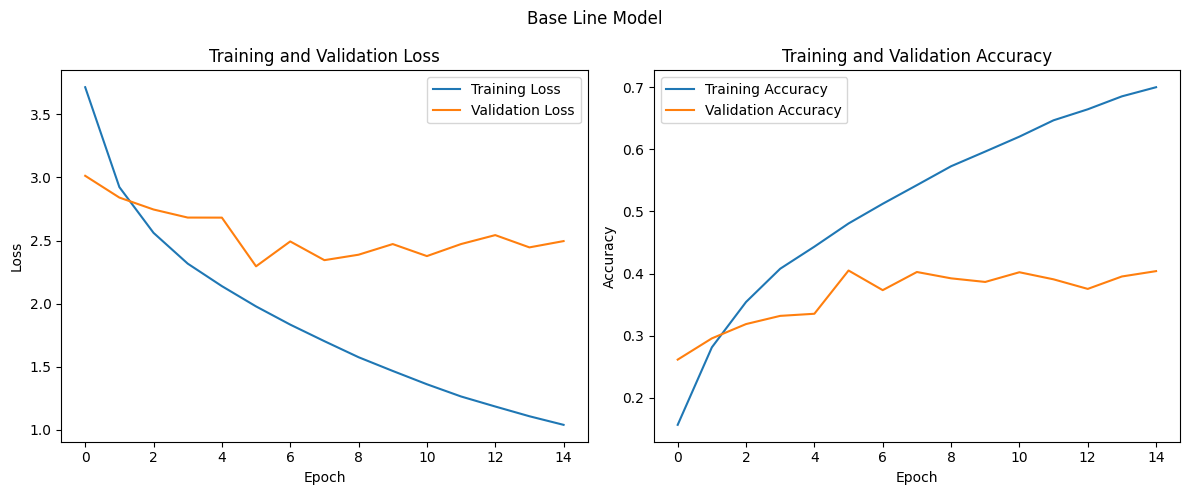

In [44]:
create_plot(history, "Base Line Model")

The model clearly overfits as can be seen by the constant decrease in training loss while the validation loss stagnates and eventually rises.

In [45]:
best_base = tfk.models.load_model("./cnn_runs/base_model.h5")
best_base.evaluate(ds_test)

200/200 [==============================] - 2s 8ms/step - loss: 2.4136 - accuracy: 0.3898


[2.4136221408843994, 0.3898000121116638]

### Global Average Pooling

In [54]:
v2 = model_v2()

In [55]:
v2.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_35 (Ba  (None, 30, 30, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_37 (Activation)  (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 13, 13, 64)        1849

In [56]:
checkpoint_path = "./cnn_runs/model_v2.h5"
checkpoint = tfk.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True
)

In [57]:
history = v2.fit(
    ds_train,
    epochs=15,
    validation_data=dsvalid,
    callbacks=[checkpoint]
)

Epoch 1/15
895/900 [============================>.] - ETA: 0s - loss: 4.1288 - accuracy: 0.0749
Epoch 1: val_loss improved from inf to 3.92478, saving model to ./cnn_runs/model_v2.h5
900/900 [==============================] - 6s 6ms/step - loss: 4.1281 - accuracy: 0.0749 - val_loss: 3.9248 - val_accuracy: 0.1096
Epoch 2/15
891/900 [============================>.] - ETA: 0s - loss: 3.8732 - accuracy: 0.1073
Epoch 2: val_loss improved from 3.92478 to 3.75672, saving model to ./cnn_runs/model_v2.h5
900/900 [==============================] - 4s 4ms/step - loss: 3.8721 - accuracy: 0.1074 - val_loss: 3.7567 - val_accuracy: 0.1306
Epoch 3/15
894/900 [============================>.] - ETA: 0s - loss: 3.7341 - accuracy: 0.1306
Epoch 3: val_loss improved from 3.75672 to 3.62369, saving model to ./cnn_runs/model_v2.h5
900/900 [==============================] - 4s 4ms/step - loss: 3.7340 - accuracy: 0.1306 - val_loss: 3.6237 - val_accuracy: 0.1524
Epoch 4/15
897/900 [============================>.

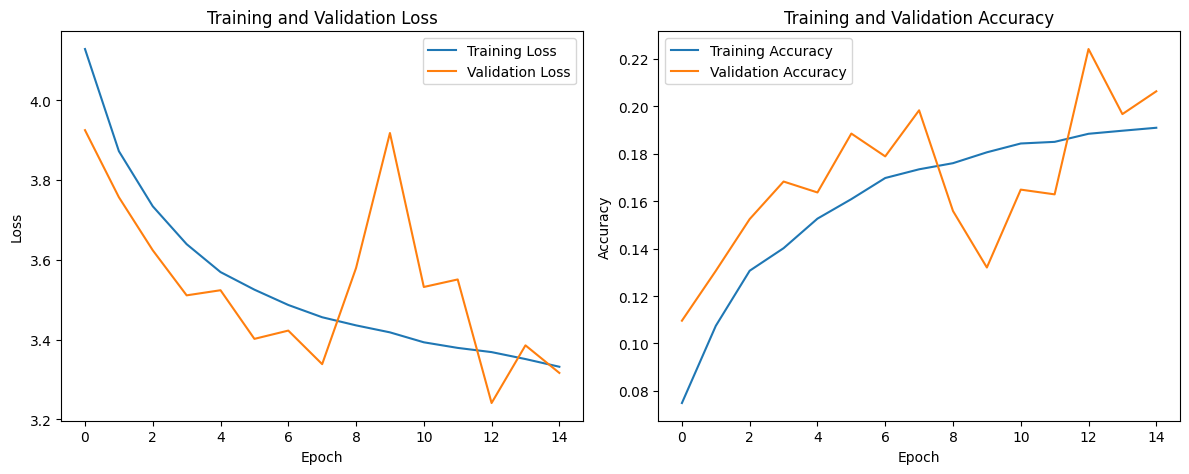

In [58]:
create_plot(history)

### Double Conv Units

In [ ]:
v3 = model_v3()

In [ ]:
v3.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_44 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_50 (Ba  (None, 30, 30, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_67 (Activation)  (None, 30, 30, 32)        0         
                                                                 
 conv2d_45 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_51 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                        

In [ ]:
checkpoint_path = "./cnn_runs/model_v3.h5"
checkpoint = tfk.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True
)

In [ ]:
history = v3.fit(
    ds_train,
    epochs=15,
    validation_data=dsvalid,
    callbacks=[checkpoint]
)

Epoch 1/15
352/352 [==============================] - ETA: 0s - loss: 3.9265 - accuracy: 0.0943
Epoch 1: val_loss improved from inf to 3.70614, saving model to ./cnn_runs/model_v3.h5
352/352 [==============================] - 5s 12ms/step - loss: 3.9265 - accuracy: 0.0943 - val_loss: 3.7061 - val_accuracy: 0.1334
Epoch 2/15
  1/352 [..............................] - ETA: 21s - loss: 3.5815 - accuracy: 0.1641

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


352/352 [==============================] - ETA: 0s - loss: 3.4965 - accuracy: 0.1596
Epoch 2: val_loss improved from 3.70614 to 3.39003, saving model to ./cnn_runs/model_v3.h5
352/352 [==============================] - 4s 12ms/step - loss: 3.4965 - accuracy: 0.1596 - val_loss: 3.3900 - val_accuracy: 0.1710
Epoch 3/15
350/352 [============================>.] - ETA: 0s - loss: 3.2791 - accuracy: 0.1951
Epoch 3: val_loss improved from 3.39003 to 3.17979, saving model to ./cnn_runs/model_v3.h5
352/352 [==============================] - 4s 12ms/step - loss: 3.2787 - accuracy: 0.1952 - val_loss: 3.1798 - val_accuracy: 0.2080
Epoch 4/15
347/352 [============================>.] - ETA: 0s - loss: 3.1460 - accuracy: 0.2192
Epoch 4: val_loss improved from 3.17979 to 3.09548, saving model to ./cnn_runs/model_v3.h5
352/352 [==============================] - 4s 11ms/step - loss: 3.1449 - accuracy: 0.2194 - val_loss: 3.0955 - val_accuracy: 0.2202
Epoch 5/15
351/352 [============================>.] - 

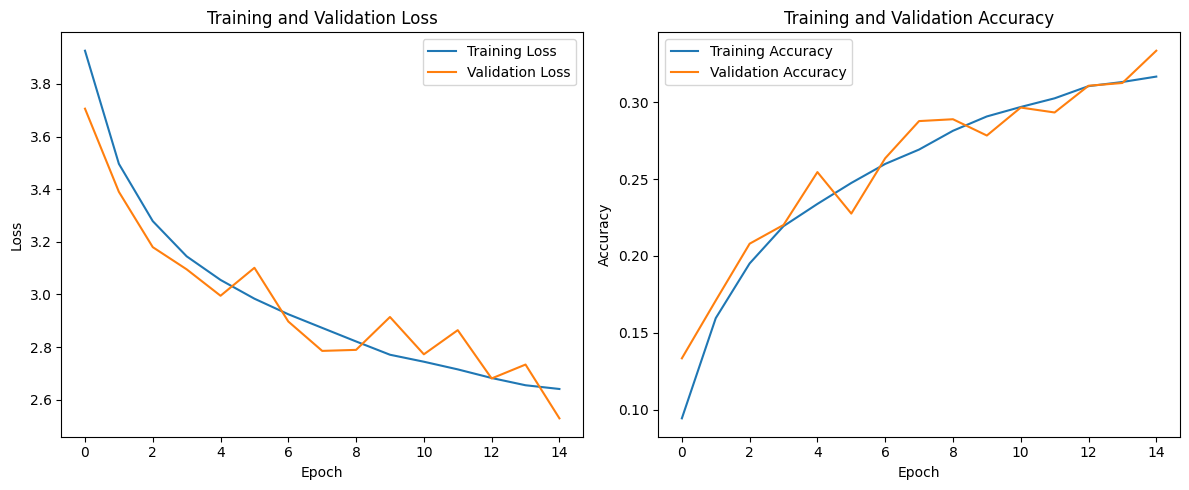

In [ ]:
create_plot(history)

This model shows a steady decline in the validation loss, and as such to observe it's full potential, the model will be trained for twice the number of epochs.

In [ ]:
v3 = model_v3()

In [ ]:
checkpoint_path = "./cnn_runs/model_v3_ex2.h5"
checkpoint = tfk.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    verbose=0,
    save_best_only=True
)

In [ ]:
history = v3.fit(
    ds_train,
    epochs=30,
    validation_data=dsvalid,
    callbacks=[checkpoint]
)

Epoch 1/30
352/352 [==============================] - 6s 11ms/step - loss: 3.9123 - accuracy: 0.0957 - val_loss: 3.9476 - val_accuracy: 0.0950
Epoch 2/30
  1/352 [..............................] - ETA: 20s - loss: 3.7349 - accuracy: 0.1172

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


352/352 [==============================] - 4s 12ms/step - loss: 3.4961 - accuracy: 0.1609 - val_loss: 3.3818 - val_accuracy: 0.1792
Epoch 3/30
352/352 [==============================] - 4s 11ms/step - loss: 3.2864 - accuracy: 0.1961 - val_loss: 3.4690 - val_accuracy: 0.1538
Epoch 4/30
352/352 [==============================] - 4s 11ms/step - loss: 3.1577 - accuracy: 0.2197 - val_loss: 2.9589 - val_accuracy: 0.2582
Epoch 5/30
352/352 [==============================] - 4s 11ms/step - loss: 3.0557 - accuracy: 0.2381 - val_loss: 3.0268 - val_accuracy: 0.2382
Epoch 6/30
352/352 [==============================] - 4s 12ms/step - loss: 2.9820 - accuracy: 0.2514 - val_loss: 3.0603 - val_accuracy: 0.2504
Epoch 7/30
352/352 [==============================] - 4s 11ms/step - loss: 2.9223 - accuracy: 0.2630 - val_loss: 2.7605 - val_accuracy: 0.2966
Epoch 8/30
352/352 [==============================] - 4s 12ms/step - loss: 2.8752 - accuracy: 0.2719 - val_loss: 2.9244 - val_accuracy: 0.2638
Epoch 9/30

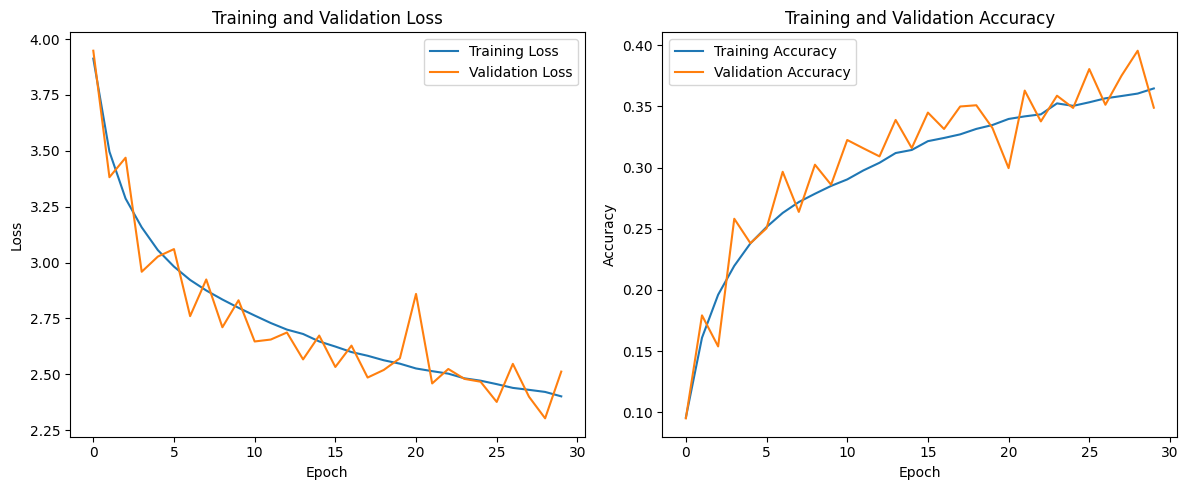

In [ ]:
create_plot(history)

The progression of the loss curves still suggests that more power can be added to the model.

In [ ]:
v3_best = tfk.models.load_model('./cnn_runs/model_v3_ex2.h5')
v3_best.evaluate(ds_test)

79/79 [==============================] - 1s 6ms/step - loss: 2.2862 - accuracy: 0.4055


[2.2861926555633545, 0.40549999475479126]

This model already beats the base model by %1, however, it's still short of the expected 44% baseline.

### Three Convolution layers

In [ ]:
v4 = model_v4()

In [ ]:
v4.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_54 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_72 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_49 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_55 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                        

In [ ]:
checkpoint_path = "./cnn_runs/model_v4.h5"
checkpoint = tfk.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True
)

In [ ]:
history = v4.fit(
    ds_train,
    epochs=30,
    validation_data=dsvalid,
    callbacks=[checkpoint]
)

Epoch 1/30
352/352 [==============================] - ETA: 0s - loss: 3.8524 - accuracy: 0.1026
Epoch 1: val_loss improved from inf to 3.92976, saving model to ./cnn_runs/model_v4.h5
352/352 [==============================] - 11s 19ms/step - loss: 3.8524 - accuracy: 0.1026 - val_loss: 3.9298 - val_accuracy: 0.0988
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


349/352 [============================>.] - ETA: 0s - loss: 3.2065 - accuracy: 0.2046
Epoch 2: val_loss improved from 3.92976 to 3.05548, saving model to ./cnn_runs/model_v4.h5
352/352 [==============================] - 6s 16ms/step - loss: 3.2037 - accuracy: 0.2049 - val_loss: 3.0555 - val_accuracy: 0.2380
Epoch 3/30
350/352 [============================>.] - ETA: 0s - loss: 2.8431 - accuracy: 0.2704
Epoch 3: val_loss improved from 3.05548 to 3.03404, saving model to ./cnn_runs/model_v4.h5
352/352 [==============================] - 6s 17ms/step - loss: 2.8418 - accuracy: 0.2706 - val_loss: 3.0340 - val_accuracy: 0.2420
Epoch 4/30
349/352 [============================>.] - ETA: 0s - loss: 2.6015 - accuracy: 0.3208
Epoch 4: val_loss improved from 3.03404 to 2.61970, saving model to ./cnn_runs/model_v4.h5
352/352 [==============================] - 6s 16ms/step - loss: 2.6010 - accuracy: 0.3213 - val_loss: 2.6197 - val_accuracy: 0.3170
Epoch 5/30
350/352 [============================>.] - 

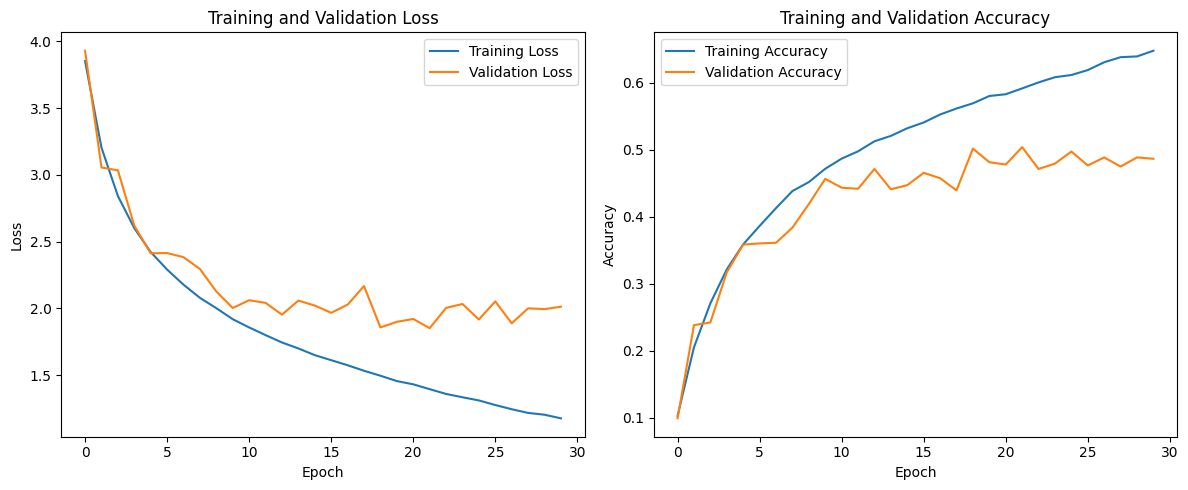

In [ ]:
create_plot(history)

In [ ]:
best_v4 = tfk.models.load_model('./cnn_runs/model_v4.h5')
v4.evaluate(ds_test)

79/79 [==============================] - 1s 14ms/step - loss: 2.0312 - accuracy: 0.4922


[2.0312416553497314, 0.49219998717308044]

### Residual Connections

In [ ]:
v5 = model_v5()

In [ ]:
v5.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_87 (Conv2D)          (None, 32, 32, 32)           896       ['input_25[0][0]']            
                                                                                                  
 batch_normalization_85 (Ba  (None, 32, 32, 32)           128       ['conv2d_87[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_106 (Activation  (None, 32, 32, 32)           0         ['batch_normalization_8

In [ ]:
checkpoint_path = "./cnn_runs/model_v5.h5"
checkpoint = tfk.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True
)

In [ ]:
v5.fit(
    ds_train,
    epochs=30,
    validation_data=dsvalid,
    callbacks=[checkpoint]
)

Epoch 1/30
352/352 [==============================] - 17s 38ms/step - loss: 3.8009 - accuracy: 0.1166 - val_loss: 3.7436 - val_accuracy: 0.1268
Epoch 2/30
352/352 [==============================] - 7s 20ms/step - loss: 3.1604 - accuracy: 0.2183 - val_loss: 3.1215 - val_accuracy: 0.2190
Epoch 3/30
352/352 [==============================] - 6s 18ms/step - loss: 2.7855 - accuracy: 0.2915 - val_loss: 2.7478 - val_accuracy: 0.3008
Epoch 4/30
352/352 [==============================] - 7s 19ms/step - loss: 2.5253 - accuracy: 0.3472 - val_loss: 2.6286 - val_accuracy: 0.3212
Epoch 5/30
352/352 [==============================] - 7s 19ms/step - loss: 2.3471 - accuracy: 0.3803 - val_loss: 2.4978 - val_accuracy: 0.3428
Epoch 6/30
352/352 [==============================] - 7s 19ms/step - loss: 2.1961 - accuracy: 0.4141 - val_loss: 2.2970 - val_accuracy: 0.3890
Epoch 7/30
352/352 [==============================] - 6s 18ms/step - loss: 2.0799 - accuracy: 0.4384 - val_loss: 2.1375 - val_accuracy: 0.427

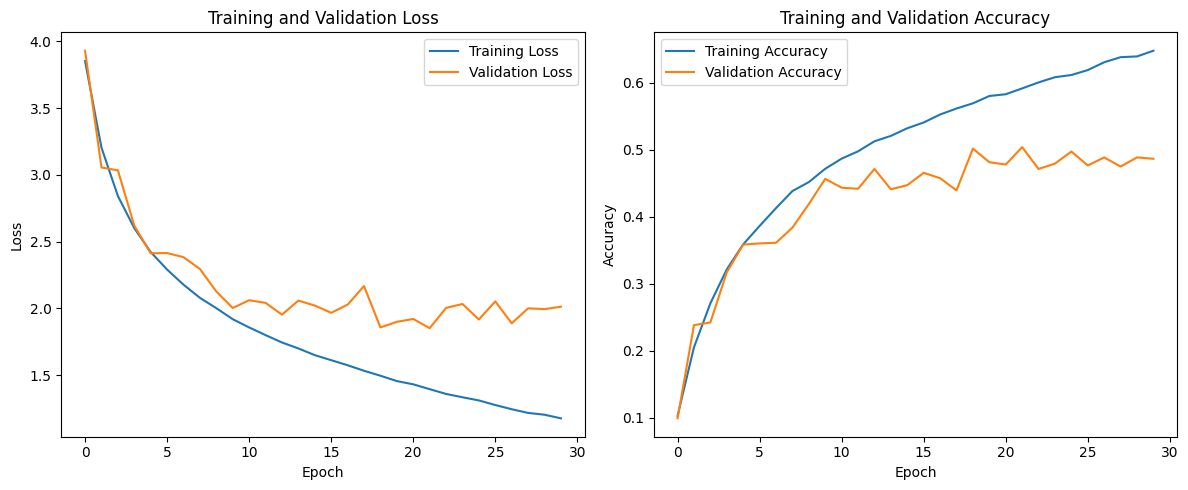

In [ ]:
create_plot(history)

In [ ]:
best_v5 = tfk.models.load_model('./cnn_runs/model_v5.h5')
best_v5.evaluate(ds_test)

79/79 [==============================] - 1s 8ms/step - loss: 1.8858 - accuracy: 0.5186


[1.8857636451721191, 0.5185999870300293]

The model using residual connection improves upon the one without by ~2%, however, it is showing signs of overfitting.

### Rescaling

An important observation to be noted is that the data isn't currently being rescaled, neural networks have issues when it comes to dealing with numbers over wide ranges and as of now, the pixels of the image range from 0 - 255, we will incorporate rescaling so the images are between 0 and 1.

In [ ]:
for x, y in ds_train:
  break

print(x.shape)
print(y.shape)

(128, 32, 32, 3)
(128,)


In [ ]:
import numpy as np
np.mean(x[0])

88.45670572916667

Evidence that the data isn't rescaled.

In [ ]:
v5 = model_v5()

In [ ]:
v5.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_28 (InputLayer)       [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 32, 32, 3)            0         ['input_28[0][0]']            
                                                                                                  
 conv2d_114 (Conv2D)         (None, 32, 32, 32)           896       ['rescaling_2[0][0]']         
                                                                                                  
 batch_normalization_103 (B  (None, 32, 32, 32)           128       ['conv2d_114[0][0]']          
 atchNormalization)                                                                        

In [ ]:
checkpoint_path = "./cnn_runs/model_v5_rs.h5"
checkpoint = tfk.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True
)

In [ ]:
v5.fit(
    ds_train,
    epochs=30,
    validation_data=dsvalid,
    callbacks=[checkpoint]
)

Epoch 1/30
352/352 [==============================] - ETA: 0s - loss: 3.9016 - accuracy: 0.1040

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


352/352 [==============================] - 45s 20ms/step - loss: 3.9016 - accuracy: 0.1040 - val_loss: 4.4717 - val_accuracy: 0.0484
Epoch 2/30
352/352 [==============================] - 7s 19ms/step - loss: 3.3817 - accuracy: 0.1832 - val_loss: 3.9555 - val_accuracy: 0.1294
Epoch 3/30
352/352 [==============================] - 7s 21ms/step - loss: 3.0344 - accuracy: 0.2446 - val_loss: 2.9662 - val_accuracy: 0.2454
Epoch 4/30
352/352 [==============================] - 6s 18ms/step - loss: 2.7953 - accuracy: 0.2883 - val_loss: 2.8466 - val_accuracy: 0.2724
Epoch 5/30
352/352 [==============================] - 7s 21ms/step - loss: 2.6076 - accuracy: 0.3227 - val_loss: 2.7684 - val_accuracy: 0.2870
Epoch 6/30
352/352 [==============================] - 7s 20ms/step - loss: 2.4629 - accuracy: 0.3571 - val_loss: 2.5444 - val_accuracy: 0.3340
Epoch 7/30
352/352 [==============================] - 7s 21ms/step - loss: 2.3320 - accuracy: 0.3852 - val_loss: 2.4126 - val_accuracy: 0.3572
Epoch 8/3

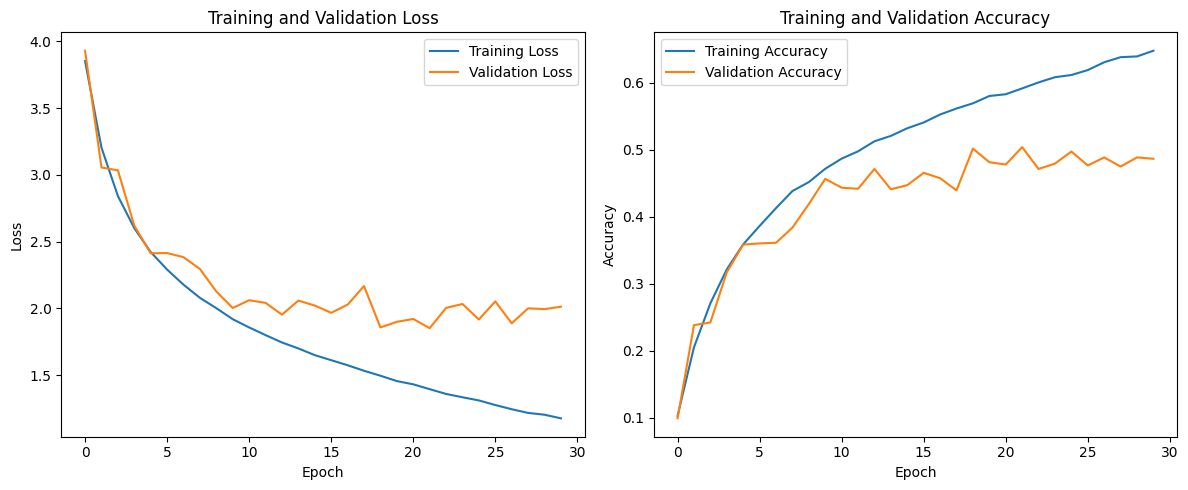

In [ ]:
create_plot(history)

In [ ]:
best_v5 = tfk.models.load_model("./cnn_runs/model_v5_rs.h5")
best_v5.evaluate(ds_test)

79/79 [==============================] - 1s 9ms/step - loss: 1.8151 - accuracy: 0.5022


[1.8151216506958008, 0.5022000074386597]

Adding rescaling doesn't seem to make much of a difference.

### Augmentation

- Random Flip
- Random Rotation
- Random Zoom

Applying augmentation should alleviate some of the overfitting issues.

In [ ]:
v6 = model_v6()

In [ ]:
v6.summary()

Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_30 (InputLayer)       [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 32, 32, 3)            0         ['input_30[0][0]']            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 32, 32, 3)            0         ['sequential_1[0][0]']        
                                                                                                  
 conv2d_132 (Conv2D)         (None, 32, 32, 32)           896       ['rescaling_4[0][0]']         
                                                                                           

In [ ]:
checkpoint_path = "./cnn_runs/model_v6.h5"
checkpoint = tfk.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True
)

In [ ]:
history = v6.fit(
    ds_train,
    epochs=30,
    callbacks=[checkpoint],
    validation_data=dsvalid
)

Epoch 1/30
350/352 [============================>.] - ETA: 0s - loss: 4.0294 - accuracy: 0.0845

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


352/352 [==============================] - 9s 23ms/step - loss: 4.0284 - accuracy: 0.0847 - val_loss: 4.1521 - val_accuracy: 0.0792
Epoch 2/30
352/352 [==============================] - 7s 21ms/step - loss: 3.6087 - accuracy: 0.1462 - val_loss: 3.5112 - val_accuracy: 0.1570
Epoch 3/30
352/352 [==============================] - 8s 23ms/step - loss: 3.4033 - accuracy: 0.1838 - val_loss: 3.3346 - val_accuracy: 0.1902
Epoch 4/30
352/352 [==============================] - 7s 20ms/step - loss: 3.2395 - accuracy: 0.2090 - val_loss: 3.2184 - val_accuracy: 0.2176
Epoch 5/30
352/352 [==============================] - 8s 23ms/step - loss: 3.1129 - accuracy: 0.2334 - val_loss: 3.1580 - val_accuracy: 0.2236
Epoch 6/30
352/352 [==============================] - 7s 20ms/step - loss: 3.0088 - accuracy: 0.2531 - val_loss: 3.1120 - val_accuracy: 0.2314
Epoch 7/30
352/352 [==============================] - 8s 22ms/step - loss: 2.9152 - accuracy: 0.2714 - val_loss: 2.7297 - val_accuracy: 0.3062
Epoch 8/30

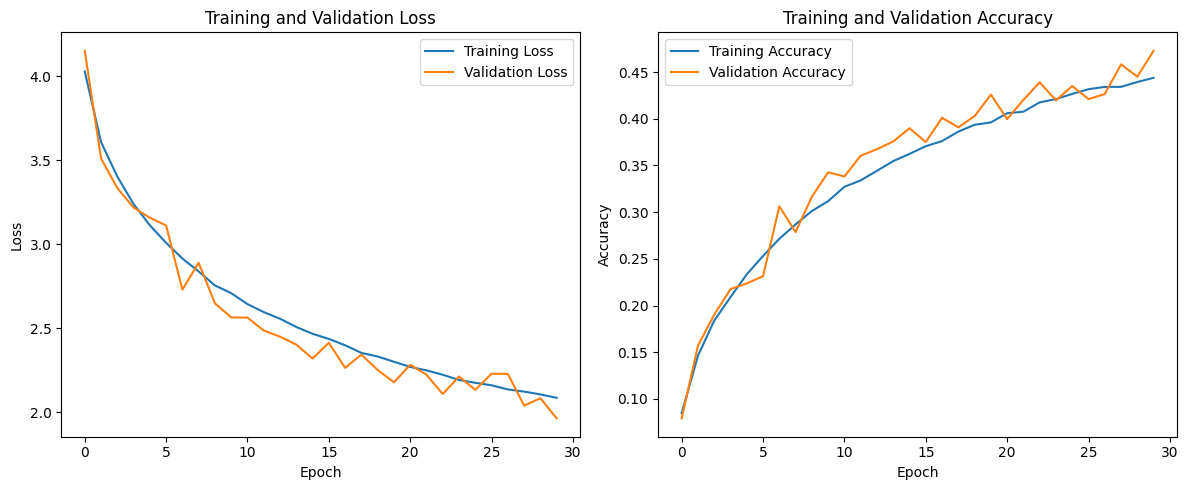

In [ ]:
create_plot(history)

Applying data augmentation has clearly mitigated overfitting, however, the progression of the loss curves shows that the model may be trained further.

In [ ]:
v6 = model_v6()

In [ ]:
checkpoint_path = "./cnn_runs/model_v6_ex2.h5"
checkpoint = tfk.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True
)
# es = tfk.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=3,
# )

In [ ]:
history = v6.fit(
    ds_train,
    epochs=100,
    validation_data=dsvalid,
    callbacks=[checkpoint]
)

Epoch 1/100
351/352 [============================>.] - ETA: 0s - loss: 3.9900 - accuracy: 0.0901

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


352/352 [==============================] - 10s 21ms/step - loss: 3.9892 - accuracy: 0.0902 - val_loss: 4.0838 - val_accuracy: 0.0870
Epoch 2/100
352/352 [==============================] - 8s 23ms/step - loss: 3.5312 - accuracy: 0.1587 - val_loss: 3.3533 - val_accuracy: 0.1856
Epoch 3/100
352/352 [==============================] - 7s 21ms/step - loss: 3.3061 - accuracy: 0.1977 - val_loss: 3.2116 - val_accuracy: 0.2114
Epoch 4/100
352/352 [==============================] - 7s 20ms/step - loss: 3.1552 - accuracy: 0.2229 - val_loss: 3.6537 - val_accuracy: 0.1804
Epoch 5/100
352/352 [==============================] - 7s 21ms/step - loss: 3.0349 - accuracy: 0.2482 - val_loss: 2.9732 - val_accuracy: 0.2600
Epoch 6/100
352/352 [==============================] - 8s 22ms/step - loss: 2.9278 - accuracy: 0.2699 - val_loss: 2.8313 - val_accuracy: 0.2844
Epoch 7/100
352/352 [==============================] - 7s 19ms/step - loss: 2.8429 - accuracy: 0.2859 - val_loss: 2.8871 - val_accuracy: 0.2748
Epo

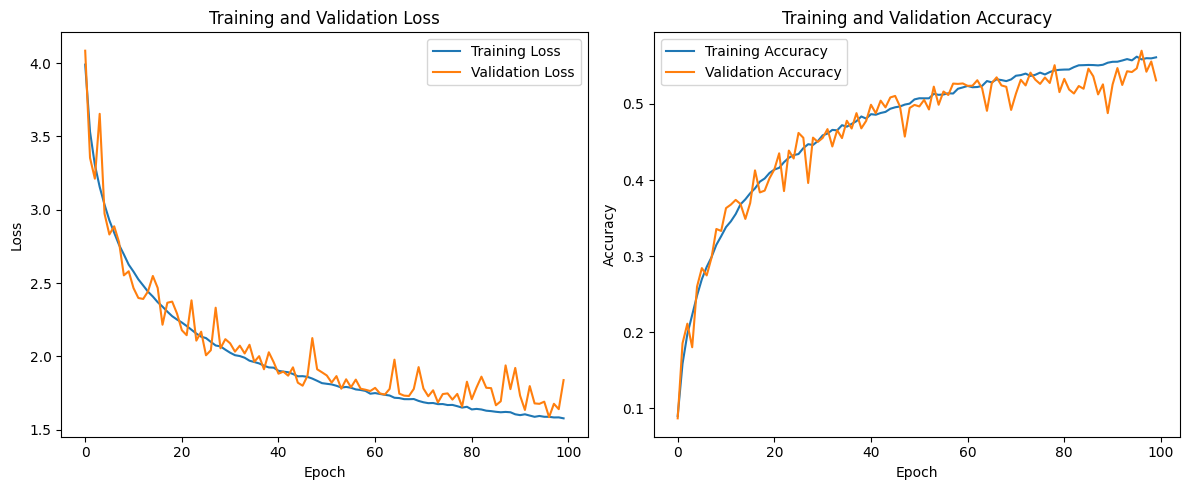

In [ ]:
create_plot(history)

In [ ]:
best_v6 = tfk.models.load_model('./cnn_runs/model_v6_ex2.h5')
best_v6.evaluate(ds_test)

79/79 [==============================] - 1s 7ms/step - loss: 1.5922 - accuracy: 0.5679


[1.5921586751937866, 0.5679000020027161]

### DepthWise Seperable Convolutions

The previous model clearly improved over its predecessor however, it was too slow, while this experiment will not concentrate on improving upon the learning time, it can serve as an indicator whether to use this type of layer going forward.

In [ ]:
v7 = model_v7()

In [ ]:
v7.summary()

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_34 (InputLayer)       [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 sequential_5 (Sequential)   (None, 32, 32, 3)            0         ['input_34[0][0]']            
                                                                                                  
 rescaling_8 (Rescaling)     (None, 32, 32, 3)            0         ['sequential_5[0][0]']        
                                                                                                  
 conv2d_159 (Conv2D)         (None, 32, 32, 32)           896       ['rescaling_8[0][0]']         
                                                                                           

A clear sign of using separable convolutions is that the number of parameters is drastically reduced.

In [ ]:
checkpoint_path = "./cnn_runs/model_v7.h5"
checkpoint = tfk.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True
)

In [ ]:
history = v7.fit(
    ds_train,
    epochs=100,
    validation_data=dsvalid,
    callbacks=[checkpoint]
)

Epoch 1/100
352/352 [==============================] - ETA: 0s - loss: 3.9673 - accuracy: 0.0904

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


352/352 [==============================] - 10s 24ms/step - loss: 3.9673 - accuracy: 0.0904 - val_loss: 4.3865 - val_accuracy: 0.0410
Epoch 2/100
352/352 [==============================] - 6s 18ms/step - loss: 3.5456 - accuracy: 0.1554 - val_loss: 3.6048 - val_accuracy: 0.1568
Epoch 3/100
352/352 [==============================] - 7s 19ms/step - loss: 3.3540 - accuracy: 0.1917 - val_loss: 3.2141 - val_accuracy: 0.2186
Epoch 4/100
352/352 [==============================] - 6s 17ms/step - loss: 3.2318 - accuracy: 0.2116 - val_loss: 3.0741 - val_accuracy: 0.2398
Epoch 5/100
352/352 [==============================] - 6s 17ms/step - loss: 3.1345 - accuracy: 0.2314 - val_loss: 2.9369 - val_accuracy: 0.2686
Epoch 6/100
352/352 [==============================] - 6s 16ms/step - loss: 3.0588 - accuracy: 0.2447 - val_loss: 3.0149 - val_accuracy: 0.2674
Epoch 7/100
352/352 [==============================] - 6s 17ms/step - loss: 2.9977 - accuracy: 0.2561 - val_loss: 2.8732 - val_accuracy: 0.2836
Epo

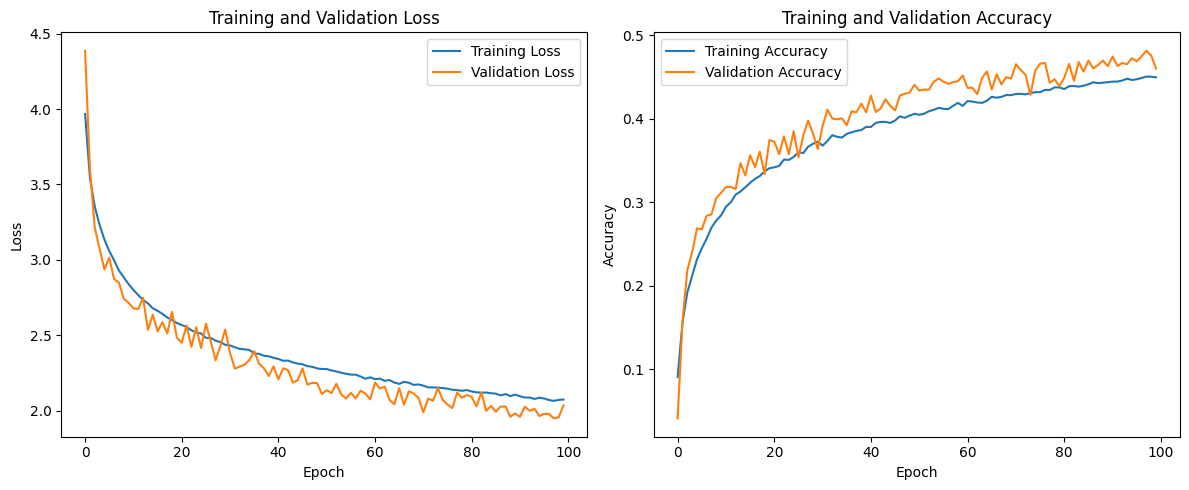

In [ ]:
create_plot(history)

### Deep Powerful Model

In [33]:
v8 = model_v8()
v8.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32, 32, 3)            0         ['input_5[0][0]']             
                                                                                                  
 rescaling (Rescaling)       (None, 32, 32, 3)            0         ['sequential[0][0]']          
                                                                                                  
 conv2d_8 (Conv2D)           (None, 32, 32, 64)           1792      ['rescaling[0][0]']           
                                                                                            

In [34]:
checkpoint_path = "./cnn_runs/model_v8.h5"
checkpoint = tfk.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True
)

In [35]:
history = v8.fit(
    ds_train,
    epochs=15,
    validation_data=dsvalid,
    callbacks=[checkpoint]
)

Epoch 1/15
352/352 [==============================] - 50s 126ms/step - loss: 4.5146 - accuracy: 0.0697 - val_loss: 4.6559 - val_accuracy: 0.0472
Epoch 2/15
352/352 [==============================] - 42s 119ms/step - loss: 3.7066 - accuracy: 0.1318 - val_loss: 3.3427 - val_accuracy: 0.1872
Epoch 3/15
352/352 [==============================] - 48s 135ms/step - loss: 3.4002 - accuracy: 0.1817 - val_loss: 3.2011 - val_accuracy: 0.2102
Epoch 4/15
352/352 [==============================] - 41s 117ms/step - loss: 3.1994 - accuracy: 0.2131 - val_loss: 3.0816 - val_accuracy: 0.2400
Epoch 5/15
352/352 [==============================] - 42s 118ms/step - loss: 3.0307 - accuracy: 0.2475 - val_loss: 2.8607 - val_accuracy: 0.2756
Epoch 6/15
352/352 [==============================] - 42s 120ms/step - loss: 2.8751 - accuracy: 0.2748 - val_loss: 2.7129 - val_accuracy: 0.3152
Epoch 7/15
352/352 [==============================] - 41s 116ms/step - loss: 2.7394 - accuracy: 0.3000 - val_loss: 2.6529 - val_ac

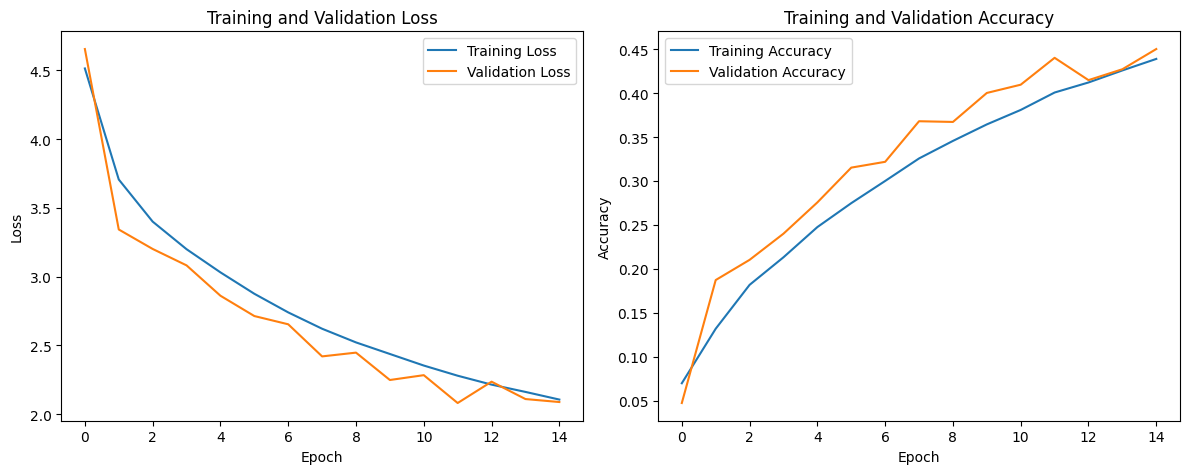

In [36]:
create_plot(history)

## Individual Class Accuracies

In this section we extract the accuracies for all 100 classes using the best model.

In [65]:
loaded_model = tfk.models.load_model('/content/drive/MyDrive/Misc/model_v8.h5')

In [67]:
predictions = loaded_model.predict(ds_test)


200/200 [==============================] - 5s 15ms/step


In [68]:
predictions.shape

(10000, 100)

In [71]:
best_class = np.argmax(predictions, axis=1)
worst_class = np.argmin(predictions, axis=1)

print(best_class.shape)
print(worst_class.shape)

(10000,)
(10000,)


In [72]:
all_y_values = []

for _, y_test in ds_test:
    all_y_values.append(y_test.numpy())  # Assuming labels are tensors

# Convert the list to a NumPy array if needed
all_y_values = np.concatenate(all_y_values, axis=0)

In [73]:
all_y_values.shape

(10000,)

In [75]:
y_pred = best_class
y_true = all_y_values

# Assuming you have arrays of predicted classes (y_pred) and actual classes (y_true)
# Each array should contain the class labels (integers)

# Calculate the overall accuracy
overall_accuracy = np.mean(y_pred == y_true)

# Calculate class accuracies
class_accuracies = []
unique_classes = np.unique(y_true)

for cls in unique_classes:
    # Get indices where the actual class is equal to cls
    class_indices = np.where(y_true == cls)

    # Extract the predicted classes for those indices
    class_predictions = y_pred[class_indices]

    # Calculate accuracy for this class
    class_accuracy = np.mean(class_predictions == cls)

    class_accuracies.append((cls, class_accuracy))

# Print overall accuracy and class accuracies
print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")

for cls, accuracy in class_accuracies:
    print(f"Class {cls} Accuracy: {accuracy * 100:.2f}%")


Overall Accuracy: 62.84%
Class 0 Accuracy: 80.00%
Class 1 Accuracy: 81.00%
Class 2 Accuracy: 53.00%
Class 3 Accuracy: 41.00%
Class 4 Accuracy: 41.00%
Class 5 Accuracy: 78.00%
Class 6 Accuracy: 64.00%
Class 7 Accuracy: 59.00%
Class 8 Accuracy: 86.00%
Class 9 Accuracy: 68.00%
Class 10 Accuracy: 33.00%
Class 11 Accuracy: 32.00%
Class 12 Accuracy: 69.00%
Class 13 Accuracy: 58.00%
Class 14 Accuracy: 73.00%
Class 15 Accuracy: 65.00%
Class 16 Accuracy: 64.00%
Class 17 Accuracy: 79.00%
Class 18 Accuracy: 72.00%
Class 19 Accuracy: 58.00%
Class 20 Accuracy: 87.00%
Class 21 Accuracy: 72.00%
Class 22 Accuracy: 77.00%
Class 23 Accuracy: 70.00%
Class 24 Accuracy: 79.00%
Class 25 Accuracy: 42.00%
Class 26 Accuracy: 53.00%
Class 27 Accuracy: 52.00%
Class 28 Accuracy: 68.00%
Class 29 Accuracy: 60.00%
Class 30 Accuracy: 70.00%
Class 31 Accuracy: 60.00%
Class 32 Accuracy: 57.00%
Class 33 Accuracy: 67.00%
Class 34 Accuracy: 60.00%
Class 35 Accuracy: 32.00%
Class 36 Accuracy: 58.00%
Class 37 Accuracy: 65.0

In [76]:
# Assuming you have class_accuracies as a list of tuples (class, accuracy)

# Sort class accuracies in descending order based on accuracy
class_accuracies.sort(key=lambda x: x[1], reverse=True)

# Get the best class (highest accuracy) and the worst class (lowest accuracy)
best_class, best_accuracy = class_accuracies[0]
worst_class, worst_accuracy = class_accuracies[-1]

# Print the best and worst classes and their accuracies
print(f"Best Class: {best_class}, Accuracy: {best_accuracy * 100:.2f}%")
print(f"Worst Class: {worst_class}, Accuracy: {worst_accuracy * 100:.2f}%")

Best Class: 68, Accuracy: 93.00%
Worst Class: 72, Accuracy: 24.00%


In [80]:
import pandas as pd

df = pd.DataFrame(class_accuracies, columns=['Class', 'Accuracy %'])

In [83]:
df.to_csv('Individual-Class-Accuracies.csv')